In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

In [11]:
print(f"Sentiment shape: {sentiment.shape} | Trader dataset shape: {trades.shape}")
print(f"Missing Values (Trades):\n{trades.isnull().sum()}")

Sentiment shape: (2644, 4) | Trader dataset shape: (211224, 16)
Missing Values (Trades):
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


In [12]:
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'], unit='ms')
trades['date'] = trades['Timestamp'].dt.date

In [13]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

In [14]:
trades['is_win'] = trades['Closed PnL'] > 0

In [15]:
trades['is_long'] = trades['Side'].str.upper().str.contains('LONG|BUY')

daily_metrics = trades.groupby(['Account', 'date']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    trades_per_day=('Trade ID', 'count'),
    avg_trade_size=('Size USD', 'mean'),
    win_rate=('is_win', 'mean'),
    long_ratio=('is_long', 'mean')
).reset_index()

In [16]:
final_data = daily_metrics.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)
final_data.rename(columns={'classification': 'sentiment'}, inplace=True)

In [17]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

/tmp/ipython-input-3342793225.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


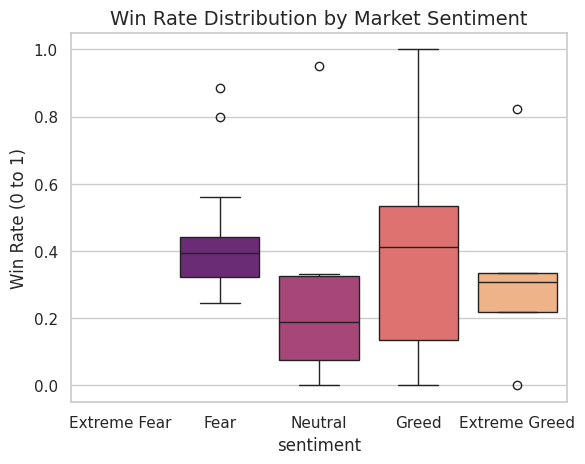

In [18]:
sns.boxplot(
    data=final_data.dropna(subset=['sentiment']),
    x='sentiment',
    y='win_rate',
    palette='magma',
    order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
)

plt.title('Win Rate Distribution by Market Sentiment', fontsize=14)
plt.ylabel('Win Rate (0 to 1)')
plt.show()

In [19]:
print("\n--- Final Merged Dataset Summary ---")
print(final_data[['date', 'daily_pnl', 'win_rate', 'sentiment']].head())


--- Final Merged Dataset Summary ---
         date     daily_pnl  win_rate sentiment
0  2024-10-27 -3.275059e+05  0.025974     Greed
1  2025-02-19  1.927736e+06  0.405542      Fear
2  2024-10-27  2.060745e+04  0.531250     Greed
3  2025-02-19  1.709873e+04  0.435041      Fear
4  2025-06-15  1.017915e+04  0.442369       NaN


In [20]:
performance_summary = final_data.groupby('sentiment').agg(
    avg_daily_pnl=('daily_pnl', 'mean'),
    avg_win_rate=('win_rate', 'mean'),
    pnl_volatility=('daily_pnl', 'std'),
    sample_size=('date', 'count')
).reindex(['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])

In [21]:
behavior_summary = final_data.groupby('sentiment').agg(
    avg_trades_per_day=('trades_per_day', 'mean'),
    avg_position_size=('avg_trade_size', 'mean'),
    avg_long_bias=('long_ratio', 'mean')
).reindex(['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])

In [22]:
trader_profiles = final_data.groupby('Account').agg(
    total_pnl=('daily_pnl', 'sum'),
    avg_win_rate=('win_rate', 'mean'),
    avg_activity=('trades_per_day', 'mean')
).reset_index()

In [23]:
median_activity = trader_profiles['avg_activity'].median()
trader_profiles['frequency_segment'] = np.where(
    trader_profiles['avg_activity'] > median_activity, 'Frequent', 'Infrequent'
)

In [24]:
trader_profiles['performance_segment'] = np.where(
    (trader_profiles['total_pnl'] > 0) & (trader_profiles['avg_win_rate'] > 0.5),
    'Consistent Winner', 'Inconsistent/Losing'
)

/tmp/ipython-input-3607326425.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=performance_summary.reset_index(), x='sentiment', y='avg_daily_pnl', ax=ax, palette='coolwarm')


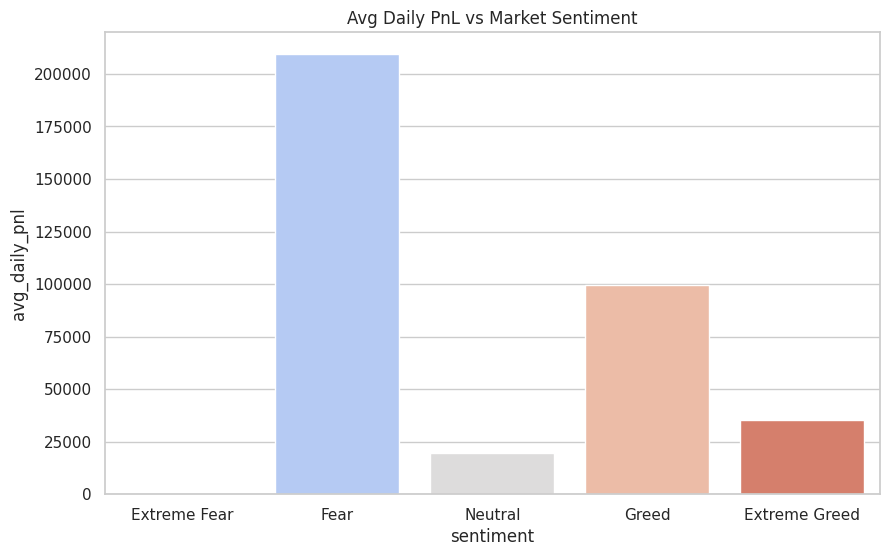

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=performance_summary.reset_index(), x='sentiment', y='avg_daily_pnl', ax=ax, palette='coolwarm')
ax.set_title('Avg Daily PnL vs Market Sentiment')
plt.show()

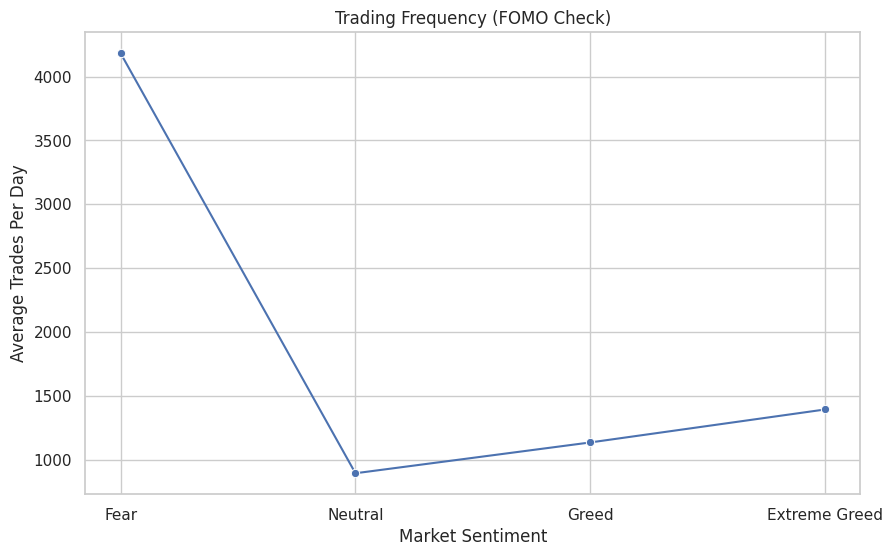

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=behavior_summary.reset_index(), x='sentiment', y='avg_trades_per_day', marker='o', ax=ax)
ax.set_title('Trading Frequency (FOMO Check)')
plt.ylabel('Average Trades Per Day')
plt.xlabel('Market Sentiment')
plt.show()

In [33]:
sns.lineplot(data=behavior_summary.reset_index(), x='sentiment', y='avg_trades_per_day', marker='o', ax=axes[1])
axes[1].set_title('Trading Frequency (FOMO Check)')

Text(0.5, 1.0, 'Trading Frequency (FOMO Check)')

In [28]:
sns.scatterplot(data=trader_profiles, x='avg_activity', y='total_pnl', hue='performance_segment', size='avg_win_rate', ax=axes[2])
axes[2].set_title('Trader Activity vs. Total Profitability')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [29]:
print("\n--- Performance Evidence ---")
print(performance_summary)
print("\n--- Behavioral Evidence ---")
print(behavior_summary)


--- Performance Evidence ---
               avg_daily_pnl  avg_win_rate  pnl_volatility  sample_size
sentiment                                                              
Extreme Fear             NaN           NaN             NaN          NaN
Fear           209372.662205      0.415878   380423.906864         32.0
Neutral         19842.797260      0.260683    57227.787895          8.0
Greed           99675.516731      0.374074   282694.285526         32.0
Extreme Greed   35393.098355      0.336609    85325.499902          5.0

--- Behavioral Evidence ---
               avg_trades_per_day  avg_position_size  avg_long_bias
sentiment                                                          
Extreme Fear                  NaN                NaN            NaN
Fear                   4183.46875        5926.522723       0.459352
Neutral                 892.62500        3793.444161       0.468967
Greed                  1134.03125        5839.310974       0.495780
Extreme Greed          1392.4